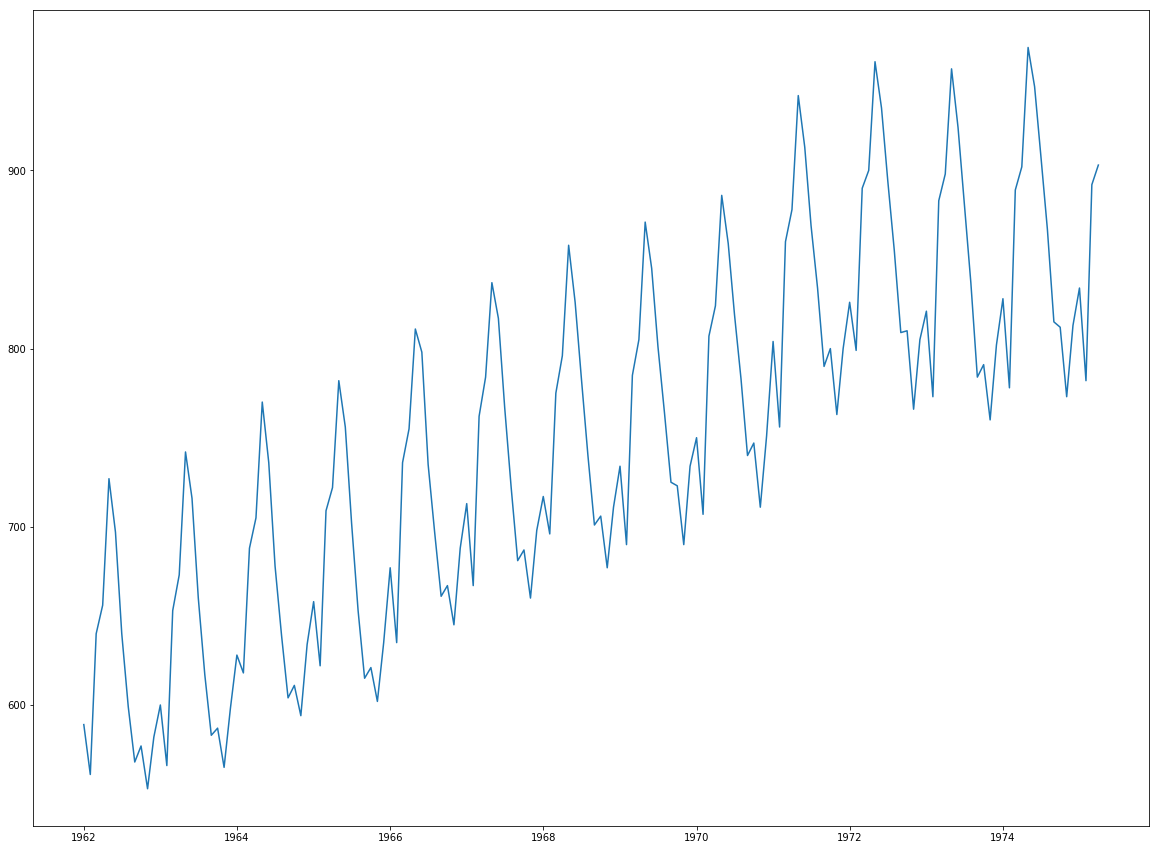

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 15 #set size of graph

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m') #set date format
data = pd.read_csv('monthly-milk-production-pounds-p (1).csv', parse_dates=['Month'], index_col='Month', nrows=160, date_parser = dateparse) #select month column
data = data.dropna() #remove NaN values

timeseries = data["Monthly milk production: pounds per cow. Jan 62 ? Dec 75"] #load milk production values
timeseries = timeseries.dropna() #drop any other NaN values (not sure why it is necessary to do it twice but an error was thrown)

plt.plot(timeseries) #plot the dates and milk production values so that we can see a trend


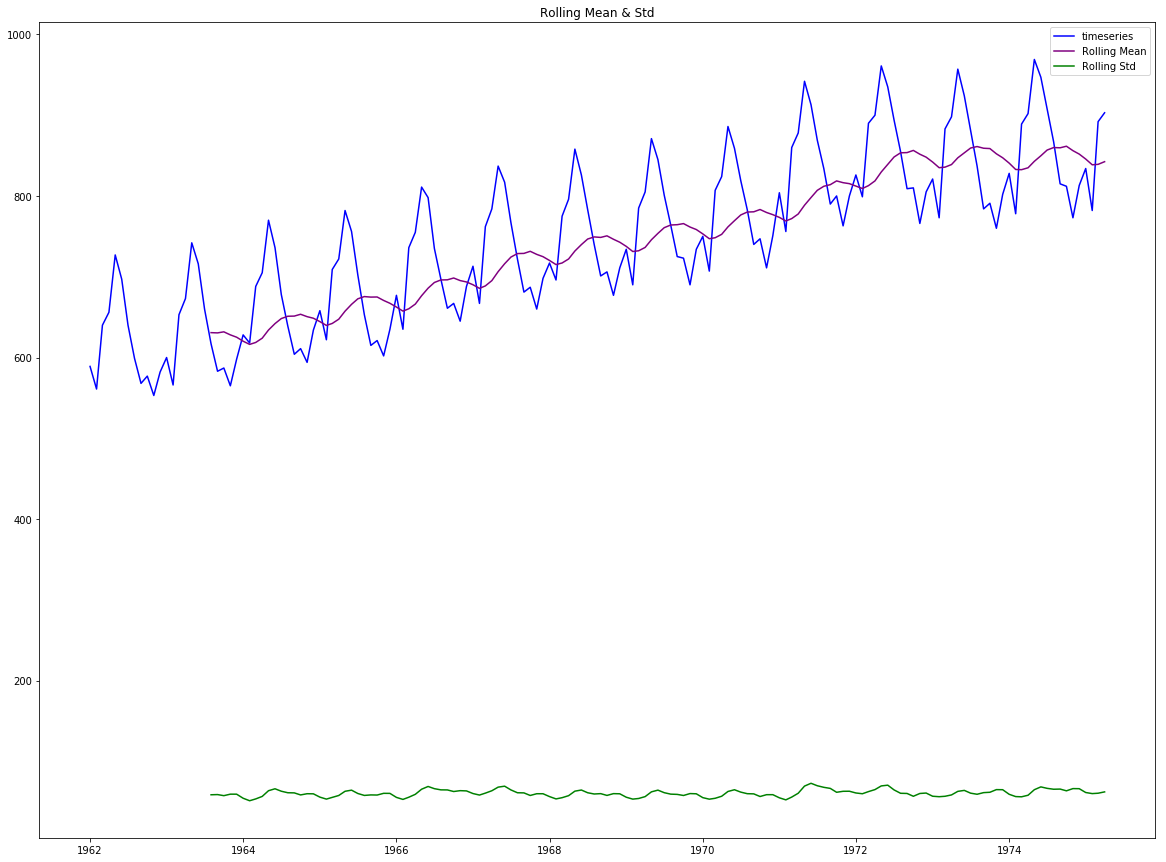

Results of D-F:
Test Statistic         -1.518984
p-value                 0.524100
Number of Lags Used    13.000000
dtype: float64


In [118]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(timeseries):
    
    rollingmean = timeseries.rolling(window=20).mean() #rolling mean of dates and milk produced
    rollingstd = timeseries.rolling(window=20).std() #std of ' '

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='timeseries')
    mean = plt.plot(rollingmean, color='purple', label='Rolling Mean')
    std = plt.plot(rollingstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std')
    plt.show(block=False)
    
    #Perform DF test:
    print ('Results of D-F:')
    dataframetest = adfuller(timeseries, autolag='AIC')
    dataframeoutput = pd.Series(dataframetest[0:3], index=['Test Statistic','p-value','Number of Lags Used'])
    
    print (dataframeoutput)
    
    #p-value>0.5 - non-stationary, else stationary 
    
testStationarity(timeseries) #test stationarity of dates and milk production


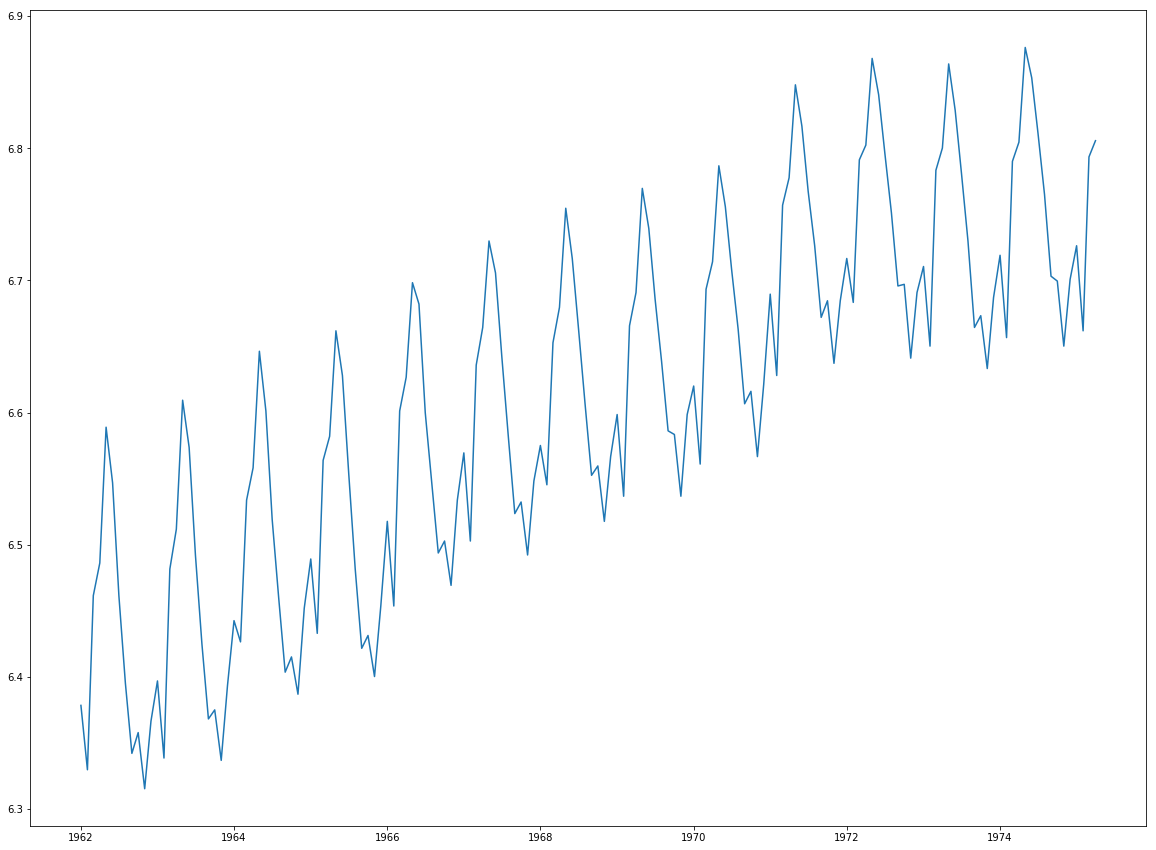

In [119]:
log_of_timeseries = np.log(timeseries)
plt.plot(log_of_timeseries) #plot log of the same timeseries


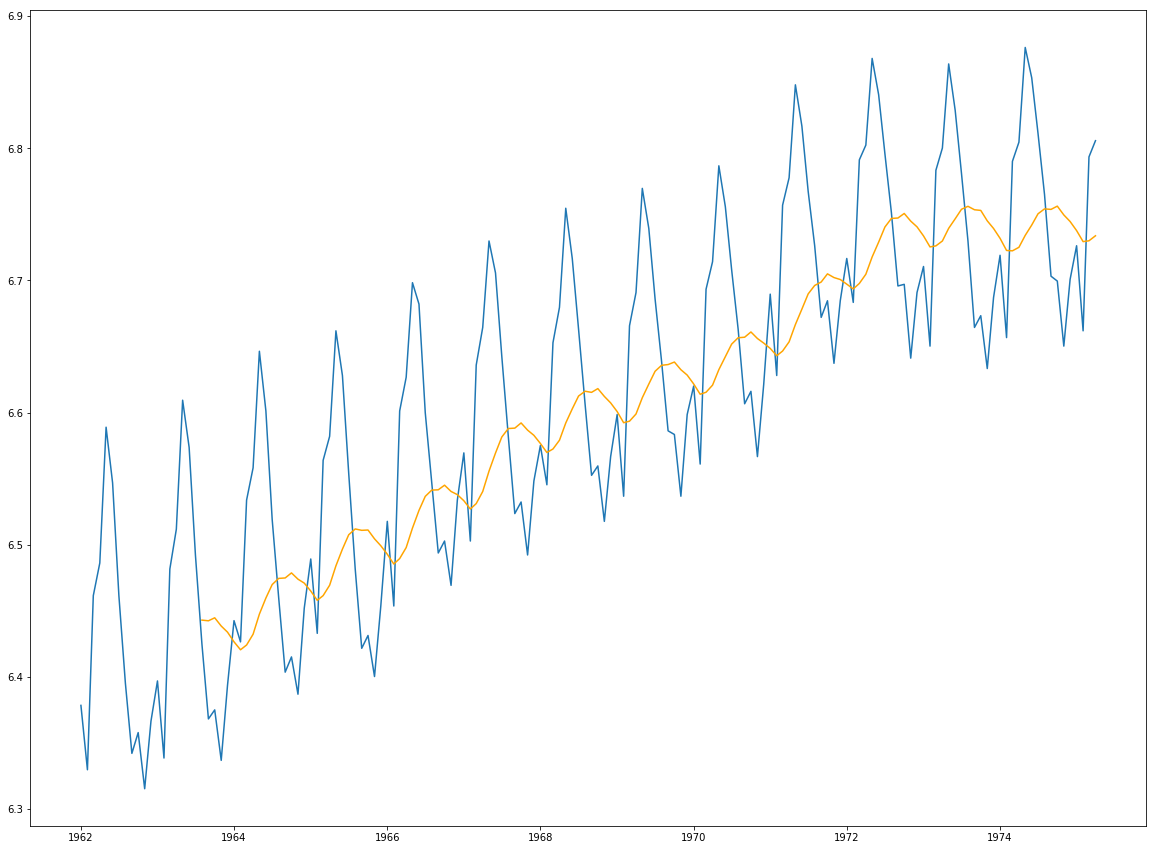

In [120]:
movingAverage = log_of_timeseries.rolling(window=20).mean()
movingSTD = log_of_timeseries.rolling(window=20).std()
plt.plot(log_of_timeseries)
plt.plot(movingAverage, color='orange') #plot moving average of timeseries


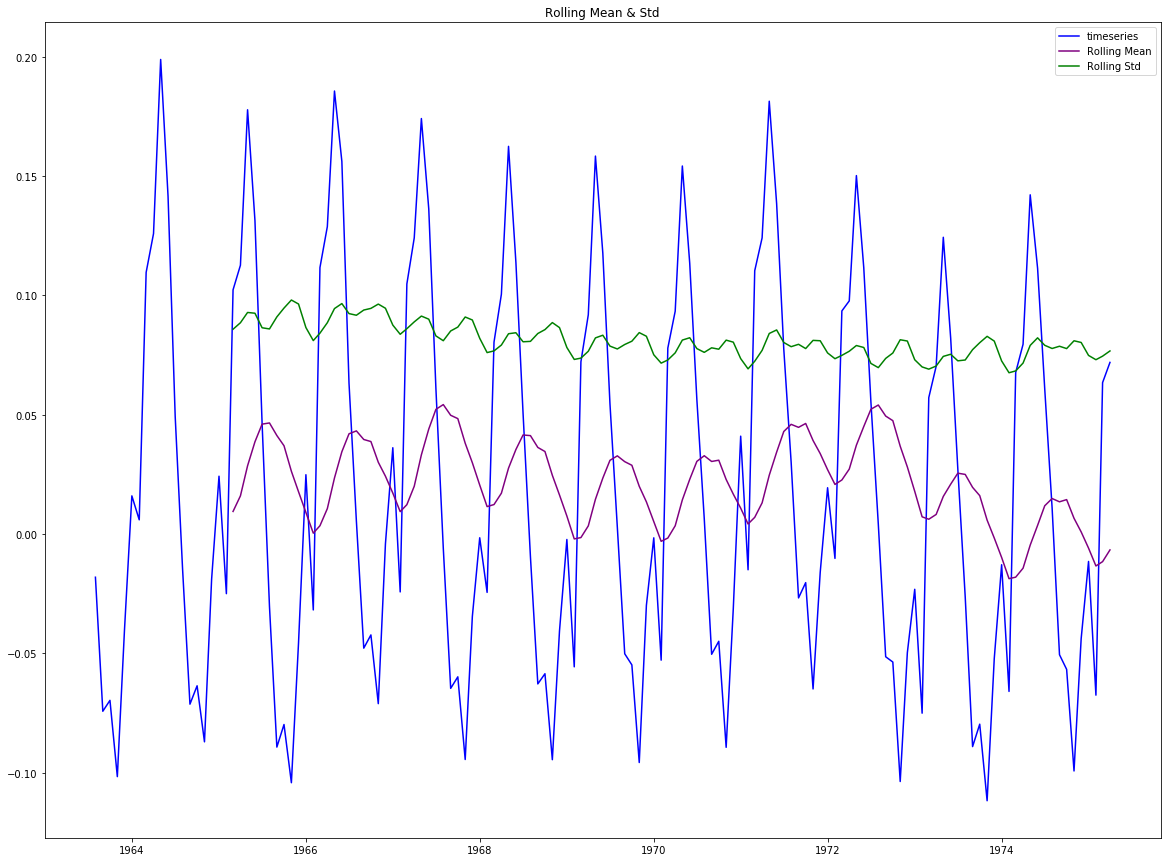

Results of D-F:
Test Statistic         -3.097879
p-value                 0.026711
Number of Lags Used    13.000000
dtype: float64


In [121]:
average_diff_of_logts = log_of_timeseries - movingAverage

average_diff_of_logts.dropna(inplace=True)
testStationarity(average_diff_of_logts)

#stationary


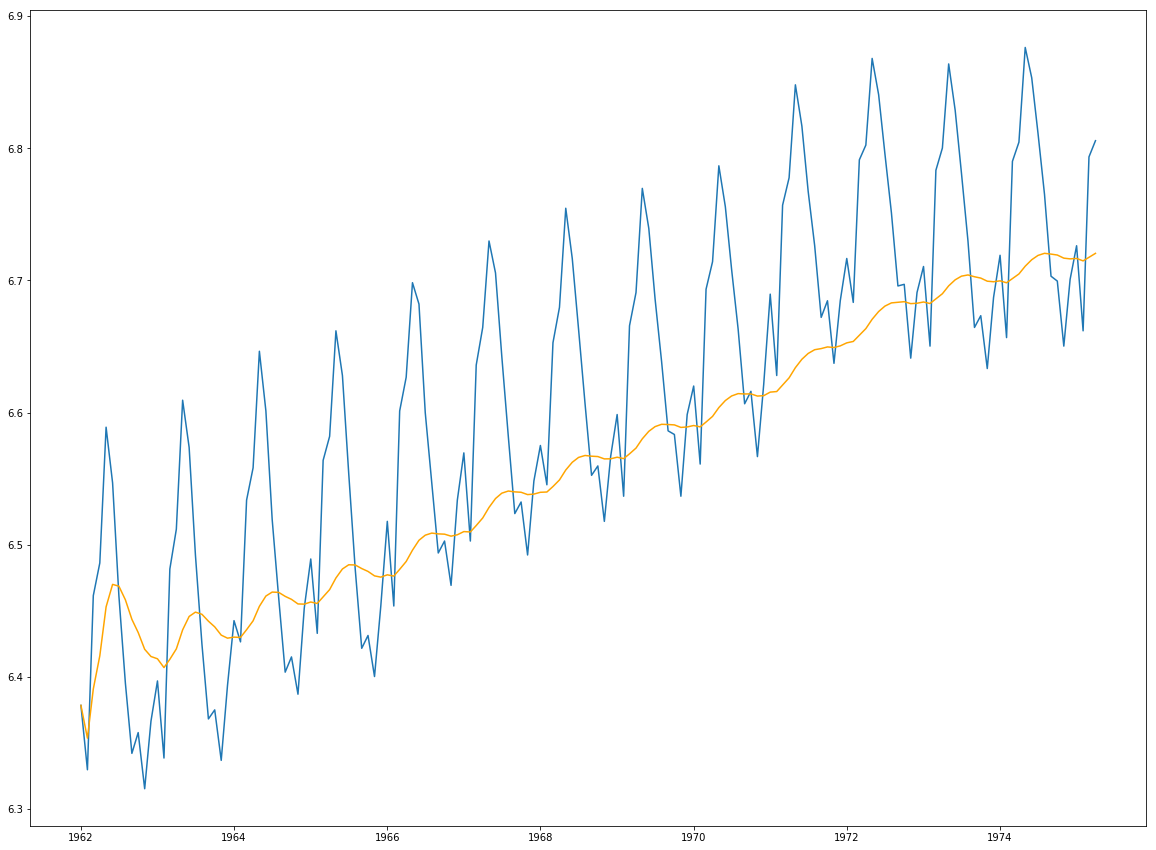

In [122]:
weighted_average_ed = log_of_timeseries.ewm(halflife=20, min_periods=0, adjust=True).mean()
plt.plot(log_of_timeseries)
plt.plot(weighted_average_ed, color='orange')

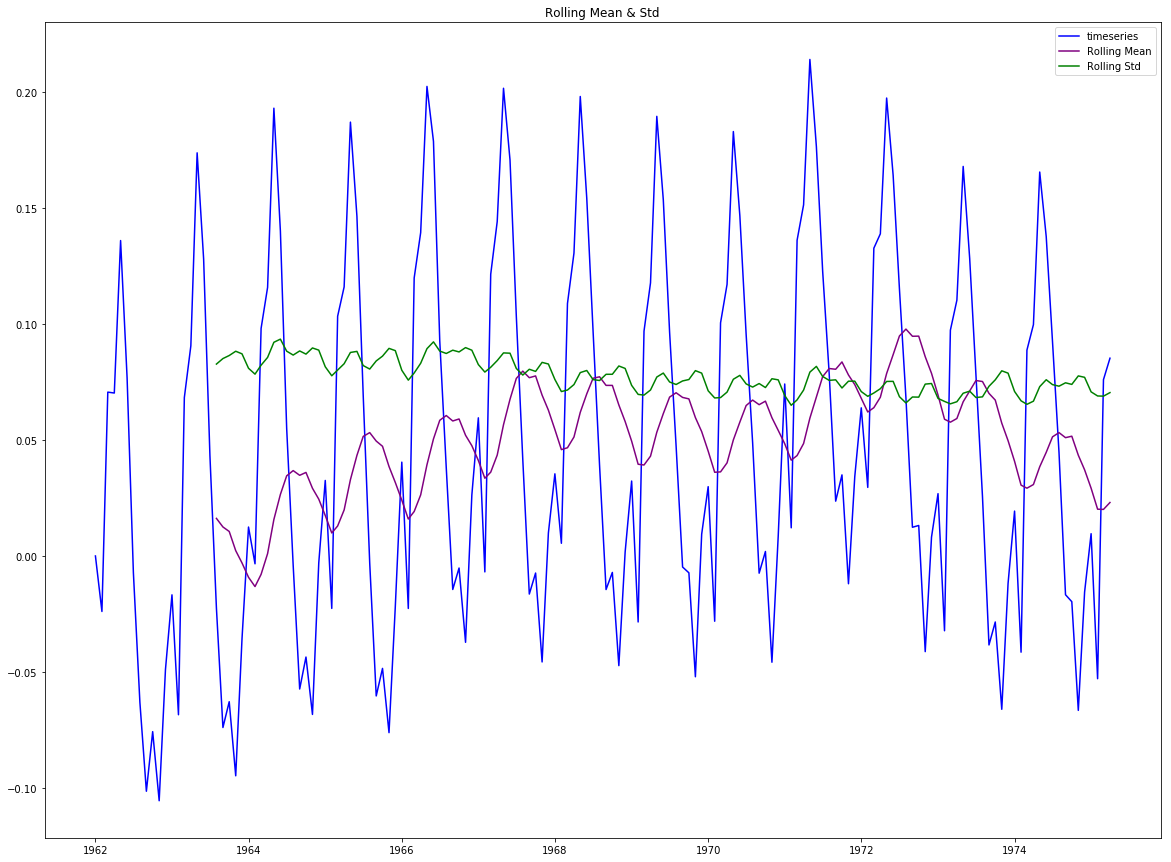

Results of D-F:
Test Statistic         -3.783822
p-value                 0.003077
Number of Lags Used    13.000000
dtype: float64


In [123]:
timeseries_log_ewma_diff = log_of_timeseries - weighted_average_ed

testStationarity(timeseries_log_ewma_diff)

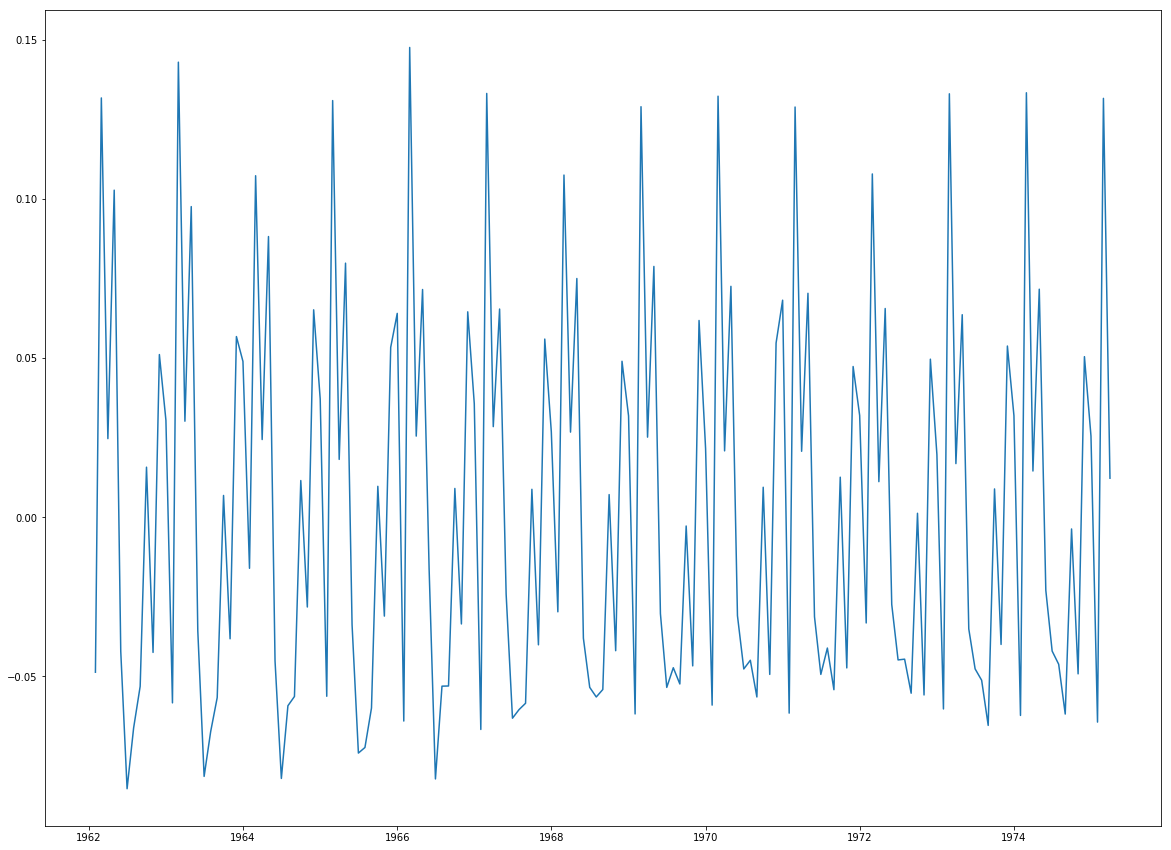

In [124]:
timeseries_log_diff = log_of_timeseries - log_of_timeseries.shift()
plt.plot(timeseries_log_diff)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


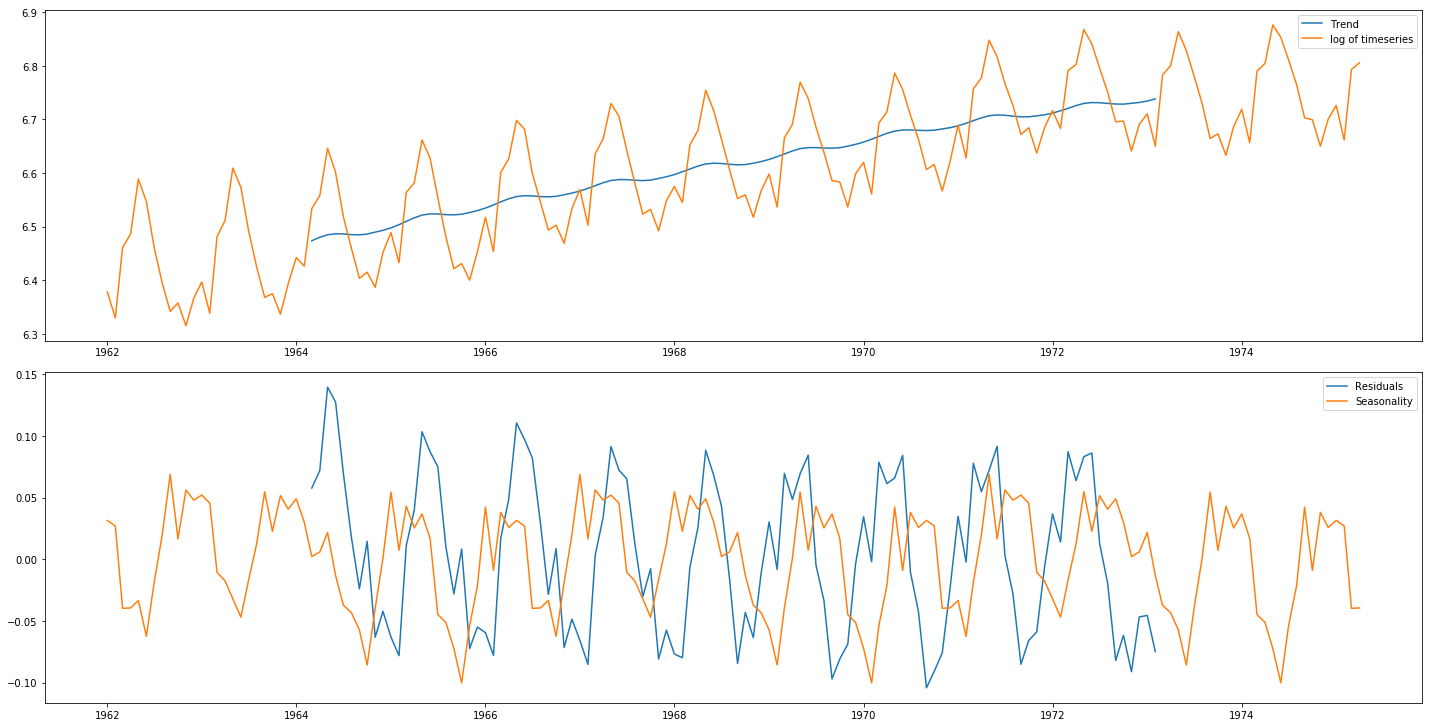

In [125]:
from statsmodels.tsa.seasonal import seasonal_decompose

series_decomp = seasonal_decompose(log_of_timeseries, freq=52) #remove componenents of the series
residual = series_decomp.resid
trend = series_decomp.trend
seasonal = series_decomp.seasonal
plt.subplot(311)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.subplot(311)
plt.plot(log_of_timeseries, label='log of timeseries')
plt.legend(loc='best')

plt.subplot(312)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')


plt.tight_layout()


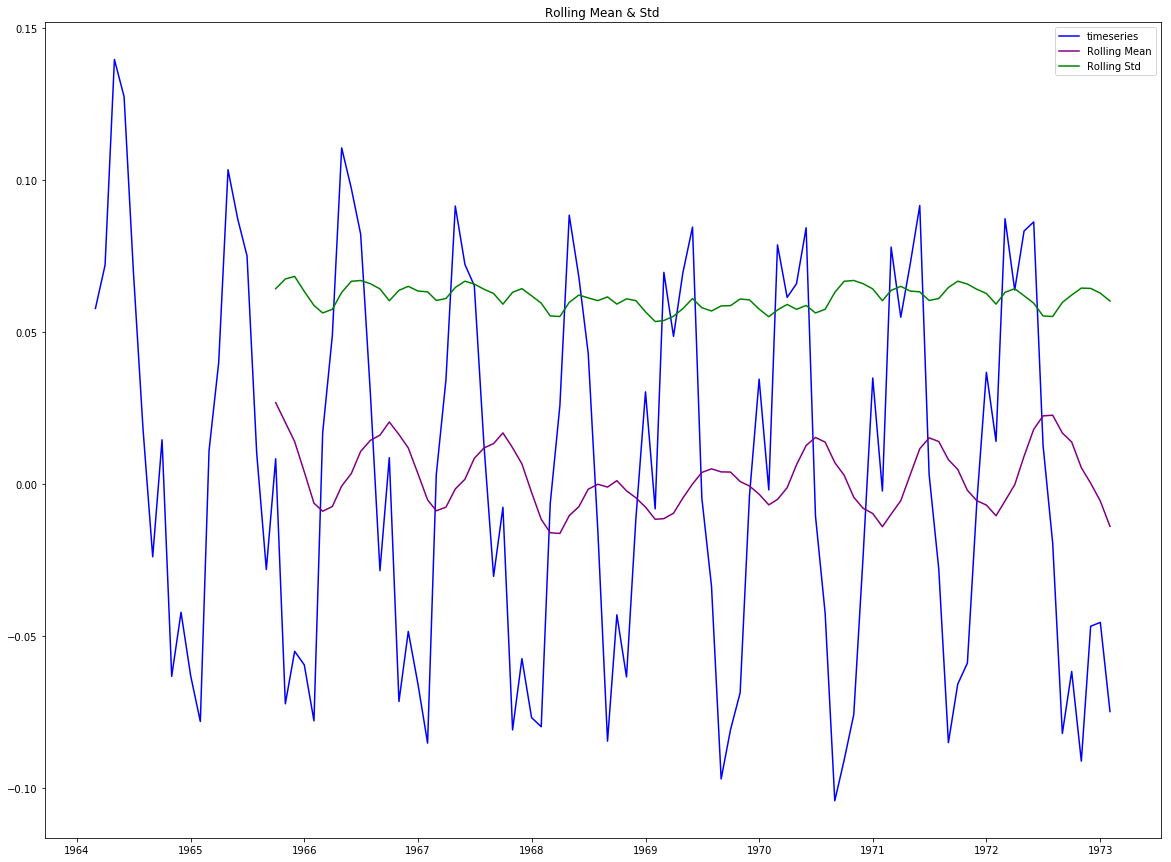

Results of D-F:
Test Statistic        -2.703431
p-value                0.073446
Number of Lags Used    8.000000
dtype: float64


In [126]:
log_timeseries_decompose = residual
log_timeseries_decompose.dropna(inplace=True)

testStationarity(log_timeseries_decompose)

Text(0.5, 1.0, 'PCF')

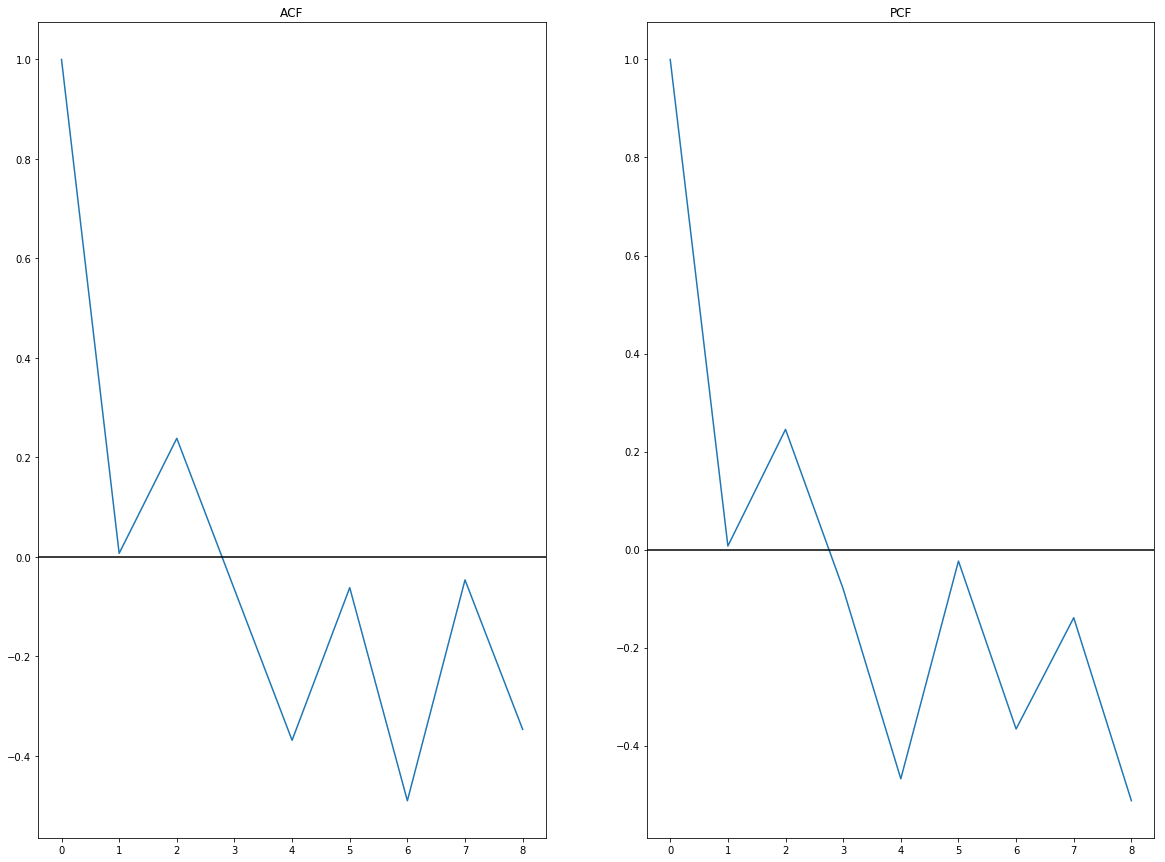

In [131]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf



timeseries_log_diff= timeseries_log_diff.dropna()
acf_lags = acf(timeseries_log_diff, nlags=8)
pacf_lags = pacf(timeseries_log_diff, nlags=8, method='ols') #ordinary least squares correlation

#Plot ACF:
plt.subplot(121)
plt.plot(acf_lags)
plt.axhline(y=0, linestyle='-', color='black')

plt.title('ACF')            

#Plot Partial -ACF
plt.subplot(122)
plt.plot(pacf_lags)
plt.axhline(y=0, linestyle='-', color='black')

plt.title('PCF')
            

#Unsure of how to read these graphs to determine order values for generated models below

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Residual Sum Squares: nan')

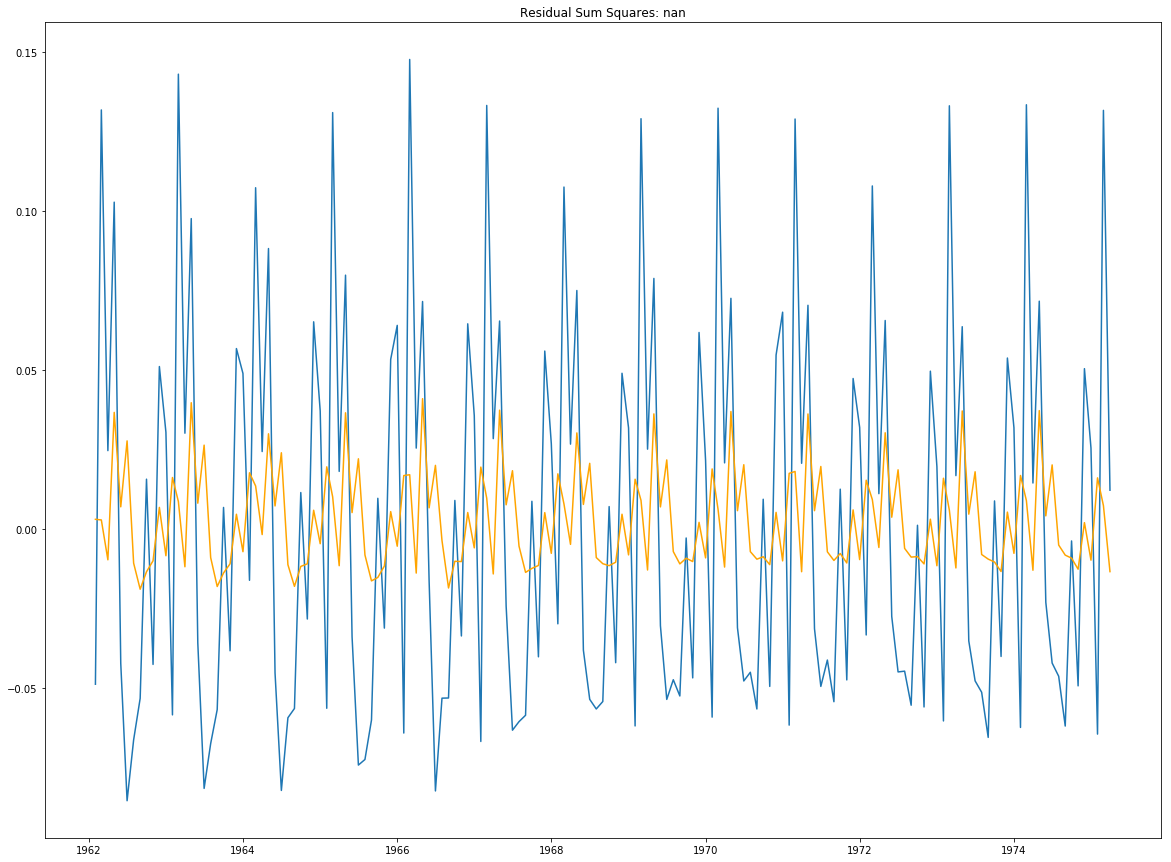

In [127]:
from statsmodels.tsa.arima_model import ARIMA  #Order values came from trial and error
#Auto
model = ARIMA(log_of_timeseries, order=(2, 1, 1))  
results_AR = model.fit(disp=-1)  
plt.plot(timeseries_log_diff)
plt.plot(results_AR.fittedvalues, color='orange')
rss = sum((results_AR.fittedvalues-timeseries_log_diff)**2)
plt.title('Residual Sum Squares: %.4f'% rss)



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Residual Sum Squares: nan')

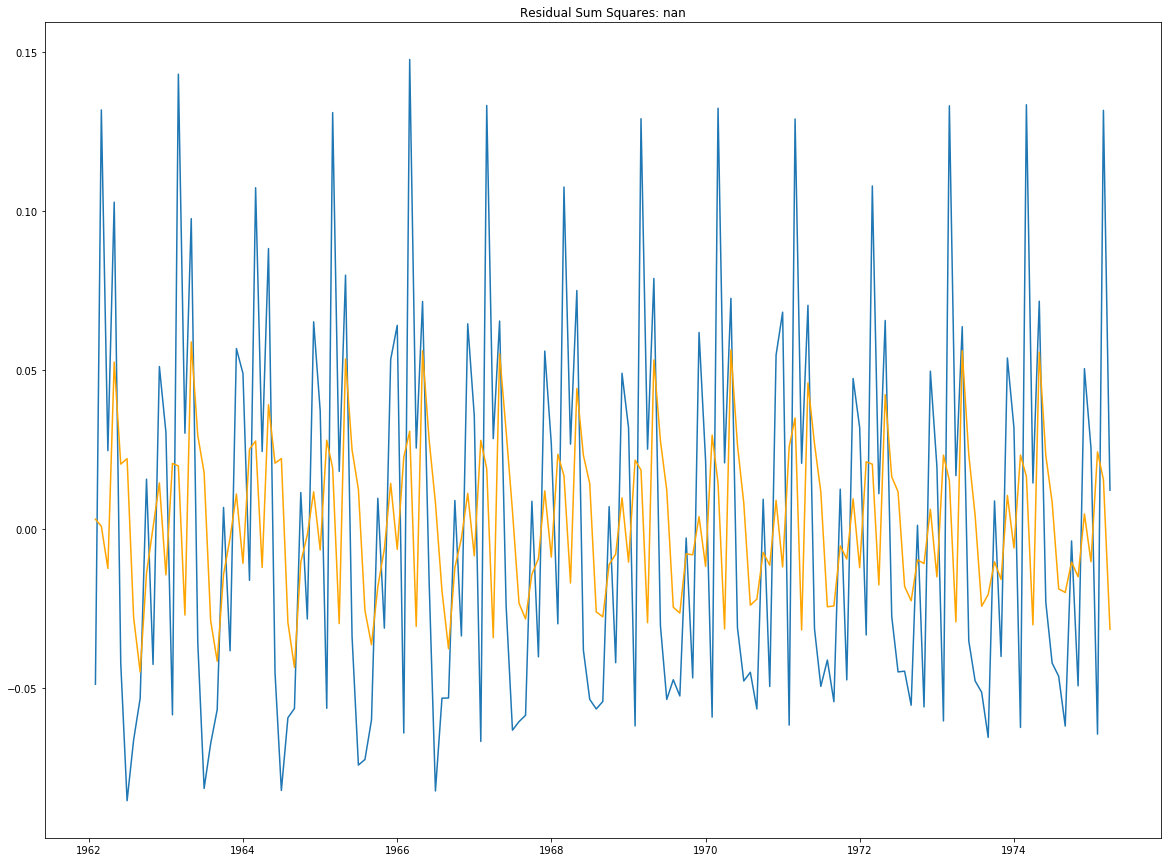

In [128]:
#moving average model
model = ARIMA(log_of_timeseries, order=(0, 1, 2)) 
results_AR = model.fit()  
plt.plot(timeseries_log_diff)
plt.plot(results_AR.fittedvalues, color='orange')
rss = sum((results_AR.fittedvalues-timeseries_log_diff)**2)
plt.title('Residual Sum Squares: %.4f'% rss)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Residual Sum Squares: nan')

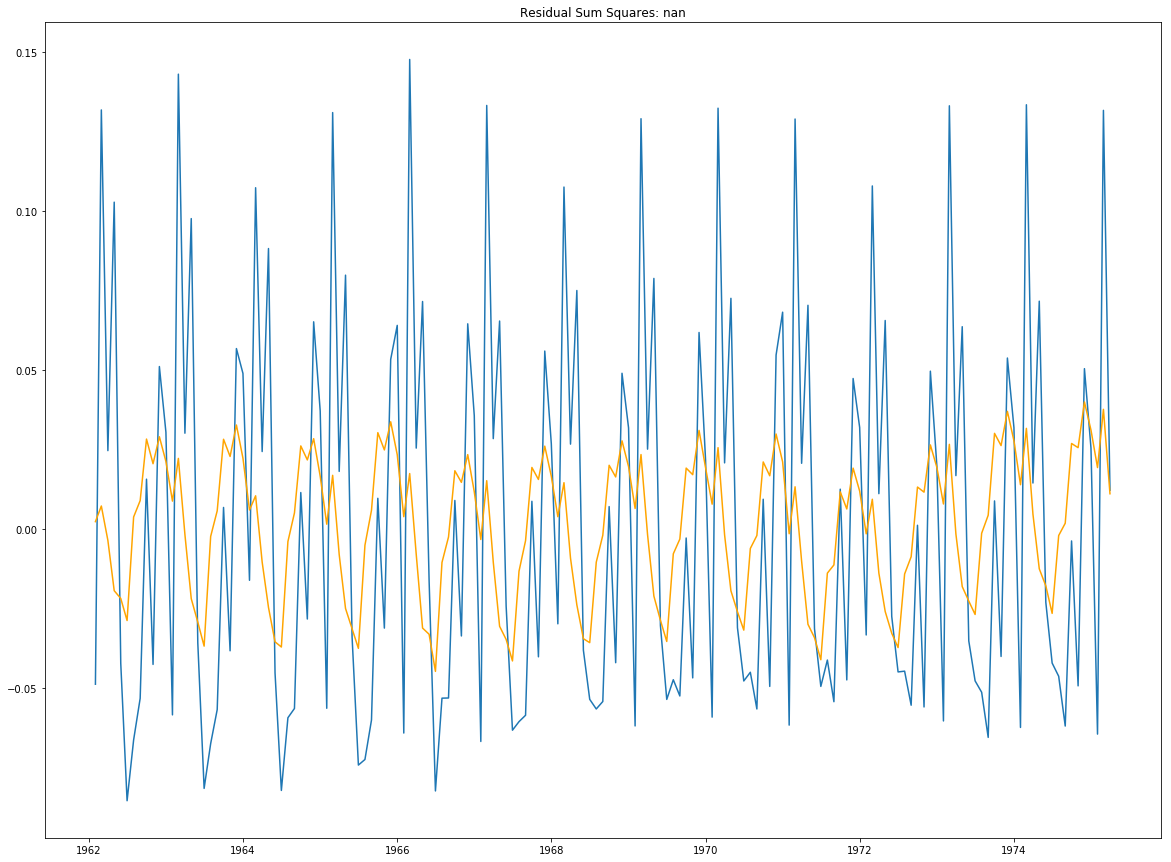

In [129]:

#arima
model = ARIMA(log_of_timeseries, order=(2, 1, 2)) 
results_AR = model.fit()  
plt.plot(timeseries_log_diff)
plt.plot(results_AR.fittedvalues, color='orange')
rss = sum((results_AR.fittedvalues-timeseries_log_diff)**2)
plt.title('Residual Sum Squares: %.4f'% rss)

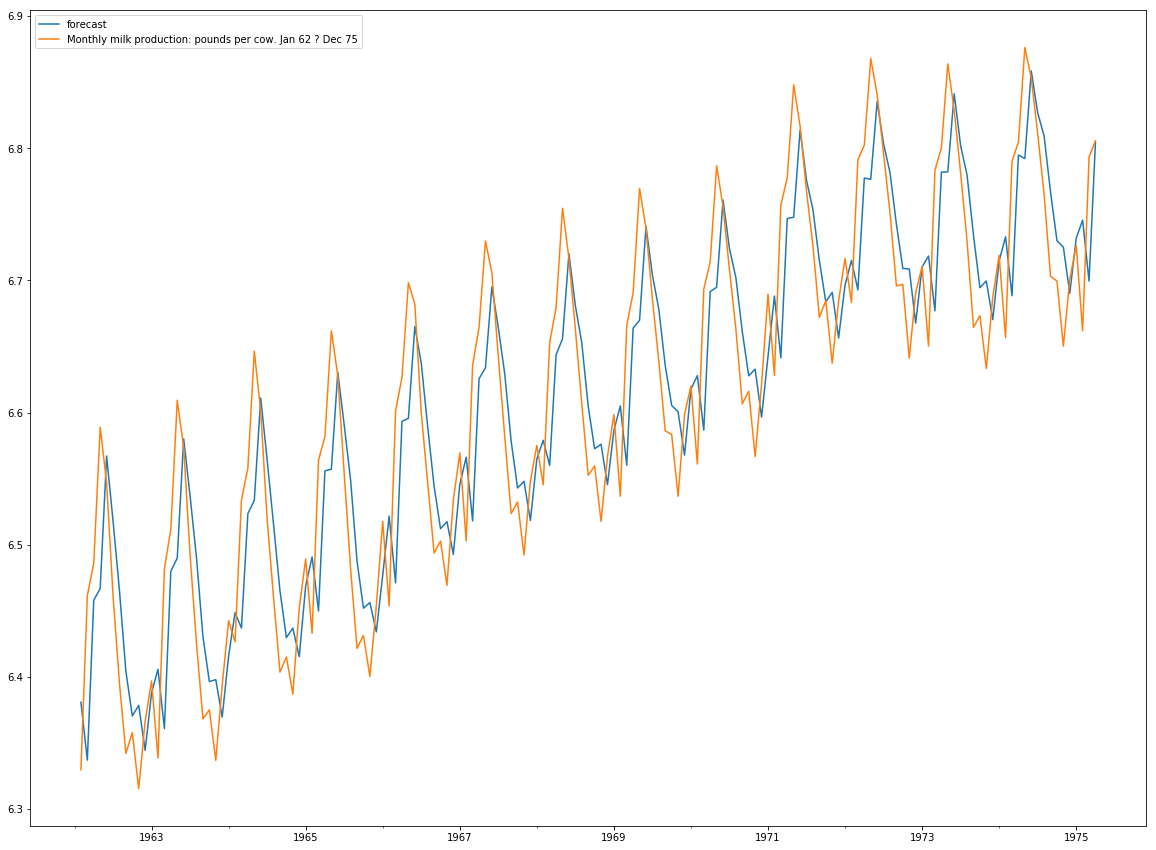

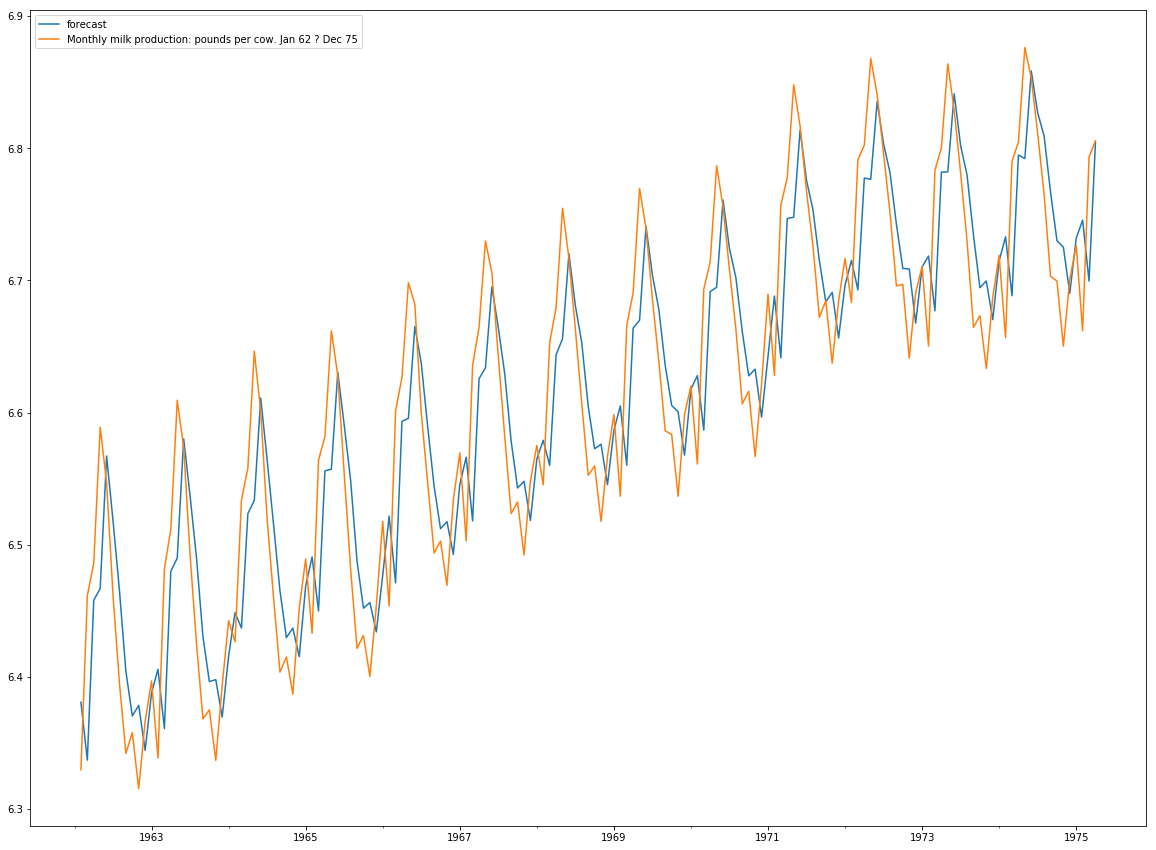

In [130]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum() #cumulative sum 


predictions_ARIMA_log = pd.Series(log_of_timeseries.iloc[0], index=timeseries.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum)


predictions_ARIMA = np.exp(predictions_ARIMA_log)

results_AR.plot_predict() #plot arima forecast vs actual values
